In [1]:
import numpy as np
import pandas as pd

df1=pd.read_csv('/Users/fabianlaw/code/fablaw/circor/raw_data/1.0.3/new_table_2.csv')
df=df1.sample(frac=1)
df

,Unnamed: 0.1,Unnamed: 0,Patient_id,select,Outcome
45,45,45,50285,MV,Abnormal
539,539,539,85305,AV,Abnormal
82,82,82,84714,AV,Abnormal
120,120,120,85207,TV,Abnormal
243,243,243,50658,PV,Normal
...,...,...,...,...,...
136,136,136,40798,AV,Abnormal
369,369,369,84764,MV,Normal
58,58,58,57700,PV,Abnormal
200,200,200,50230,AV,Normal


In [2]:
X_raw=[]
for i in df.index:
    file='../raw_data/1.0.3/proc_img/'+str(df.loc[i,'Patient_id'])+'_'+df.loc[i,'select']+'.npy'
    v=np.load(file)
    X_raw.append(v)
    
X=np.stack(X_raw)

In [3]:
y=df.Outcome.map({'Abnormal': 1, 'Normal': 0})
y.shape

(554,)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1)

In [5]:
from tensorflow.keras.layers import Dense, Flatten, MaxPooling1D, Conv1D, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.metrics import Recall

import matplotlib.pyplot as plt

In [6]:
base_model = ResNet101(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [7]:
base_model.trainable = False

In [8]:
layer1=Flatten()
layer2=Dense(1024, activation='relu')
layer3=Dense(1, activation='sigmoid')


In [9]:
model = Sequential([base_model, layer1, layer2, layer3])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 145,420,673
Trainable params: 102,762,497
Non-trainable params: 42,658,176
_________________________________________________________________


In [11]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', Recall()])

In [12]:
es=EarlyStopping(patience=10, restore_best_weights=True, monitor='val_recall')
history=model.fit(X_train, y_train, 
                  validation_split=0.2, 
                  batch_size=32, 
                  epochs=150, 
                  callbacks=[es])

Epoch 1/150


/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-01 18:20:01.635200: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 28s 3s/step - loss: 2.7561 - accuracy: 0.5049 - recall: 0.4872 - val_loss: 2.2621 - val_accuracy: 0.5128 - val_recall: 1.0000
Epoch 2/150
10/10 [==============================] - 26s 3s/step - loss: 1.2290 - accuracy: 0.5307 - recall: 0.4103 - val_loss: 1.2347 - val_accuracy: 0.5128 - val_recall: 1.0000
Epoch 3/150
10/10 [==============================] - 27s 3s/step - loss: 0.8987 - accuracy: 0.4919 - recall: 0.4744 - val_loss: 0.7247 - val_accuracy: 0.5128 - val_recall: 1.0000
Epoch 4/150
10/10 [==============================] - 27s 3s/step - loss: 0.7143 - accuracy: 0.4790 - recall: 0.5962 - val_loss: 0.7005 - val_accuracy: 0.4872 - val_recall: 0.0000e+00
Epoch 5/150
10/10 [==============================] - 28s 3s/step - loss: 0.7035 - accuracy: 0.4628 - recall: 0.4167 - val_loss: 0.6925 - val_accuracy: 0.5000 - val_recall: 0.9500
Epoch 6/150
10/10 [==============================] - 28s 3s/step - loss: 0.7127 - accuracy: 0.5243 - recall: 0.66

In [13]:
def plot_loss_recall(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    

    
    ax2.plot(history.history['recall'])
    ax2.plot(history.history['val_recall'])
    ax2.set_title('RECALL')
    ax2.set_ylabel('Recall')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

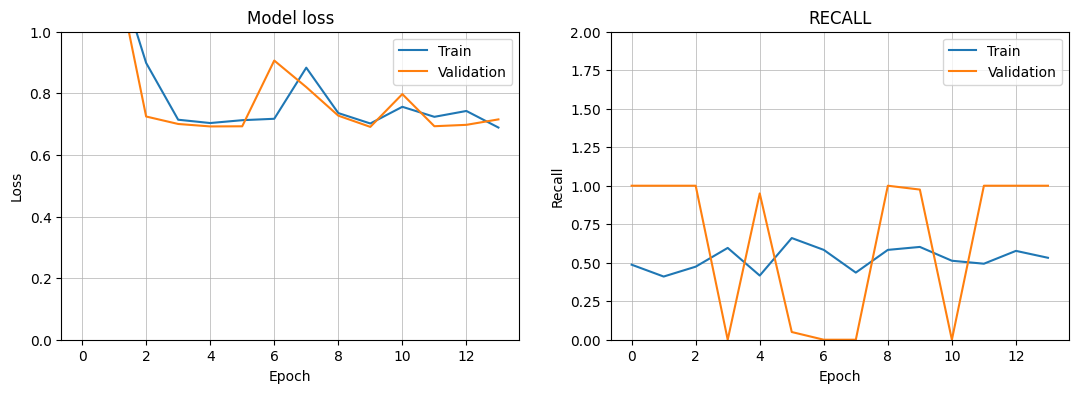

In [14]:
plot_loss_recall(history)

In [15]:
model.predict(X_test)

6/6 [==============================] - 12s 2s/step


array([[0.45334223],
       [0.44840974],
       [0.4480771 ],
       [0.45890823],
       [0.4550005 ],
       [0.4551936 ],
       [0.45225707],
       [0.4556284 ],
       [0.44662207],
       [0.45824435],
       [0.45004147],
       [0.45194265],
       [0.44975528],
       [0.43891063],
       [0.44967934],
       [0.44884583],
       [0.45345244],
       [0.45090288],
       [0.44645667],
       [0.44546425],
       [0.4504881 ],
       [0.45518696],
       [0.45113754],
       [0.45185563],
       [0.45403337],
       [0.4529666 ],
       [0.44940096],
       [0.45725426],
       [0.45215425],
       [0.44250274],
       [0.4508983 ],
       [0.45003426],
       [0.4557826 ],
       [0.44884545],
       [0.4449381 ],
       [0.44803345],
       [0.44953984],
       [0.45058846],
       [0.4556438 ],
       [0.44826907],
       [0.45251188],
       [0.45250446],
       [0.4553488 ],
       [0.45548397],
       [0.45489764],
       [0.4551406 ],
       [0.4480543 ],
       [0.455